# 1.  Dataset Loading

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo

# fetch dataset
iris = fetch_ucirepo(id=53)

# data (as pandas dataframes)
dataframe = pd.DataFrame(iris.data.features)
dataframe["class"] = pd.DataFrame(iris.data.targets)
print(dataframe)

X = iris.data.features
y = iris.data.targets

# variable information (pandas)
iris.variables
print(iris.variables)

     sepal length  sepal width  petal length  petal width           class
0             5.1          3.5           1.4          0.2     Iris-setosa
1             4.9          3.0           1.4          0.2     Iris-setosa
2             4.7          3.2           1.3          0.2     Iris-setosa
3             4.6          3.1           1.5          0.2     Iris-setosa
4             5.0          3.6           1.4          0.2     Iris-setosa
..            ...          ...           ...          ...             ...
145           6.7          3.0           5.2          2.3  Iris-virginica
146           6.3          2.5           5.0          1.9  Iris-virginica
147           6.5          3.0           5.2          2.0  Iris-virginica
148           6.2          3.4           5.4          2.3  Iris-virginica
149           5.9          3.0           5.1          1.8  Iris-virginica

[150 rows x 5 columns]
           name     role         type demographic  \
0  sepal length  Feature   Continuo

## 1.1 Handle missing values

### 1.1.1 Missing value/Data Type check

In [3]:
print(X.info(), y.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal length  150 non-null    float64
 1   sepal width   150 non-null    float64
 2   petal length  150 non-null    float64
 3   petal width   150 non-null    float64
dtypes: float64(4)
memory usage: 4.8 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   class   150 non-null    object
dtypes: object(1)
memory usage: 1.3+ KB
None None


No need for fill or drop since there are no null values. There is no need for type conversions. The only need is to hotencode the categorical data of the target data.

### 1.1.2 Factorizing

Since it is a binay classification problem we will factorize the data and not one_hot encode it

In [4]:
y = pd.factorize(y["class"])[0]

In [5]:
print(y)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


### 1.1.3 Distribution

      sepal length  sepal width  petal length  petal width
mean      5.843333     3.054000      3.758667     1.198667
std       0.828066     0.433594      1.764420     0.763161
min       4.300000     2.000000      1.000000     0.100000
25%       5.100000     2.800000      1.600000     0.300000
50%       5.800000     3.000000      4.350000     1.300000
75%       6.400000     3.300000      5.100000     1.800000
max       7.900000     4.400000      6.900000     2.500000


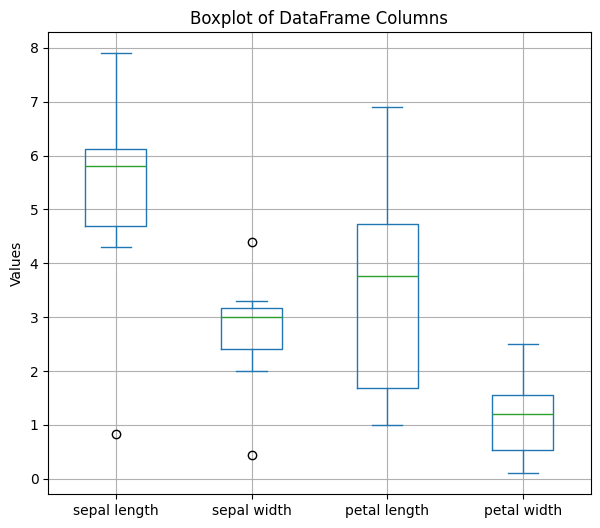

In [6]:
summary = dataframe.describe().drop("count")
print(summary)

summary.plot(kind="box", figsize=(7, 6))
plt.title("Boxplot of DataFrame Columns")
plt.ylabel("Values")
plt.grid(True)
plt.show()

We can see that we have Left skewed distributions

# 2. Visualise the Data

## 2.1 Create a pairplot according to target data

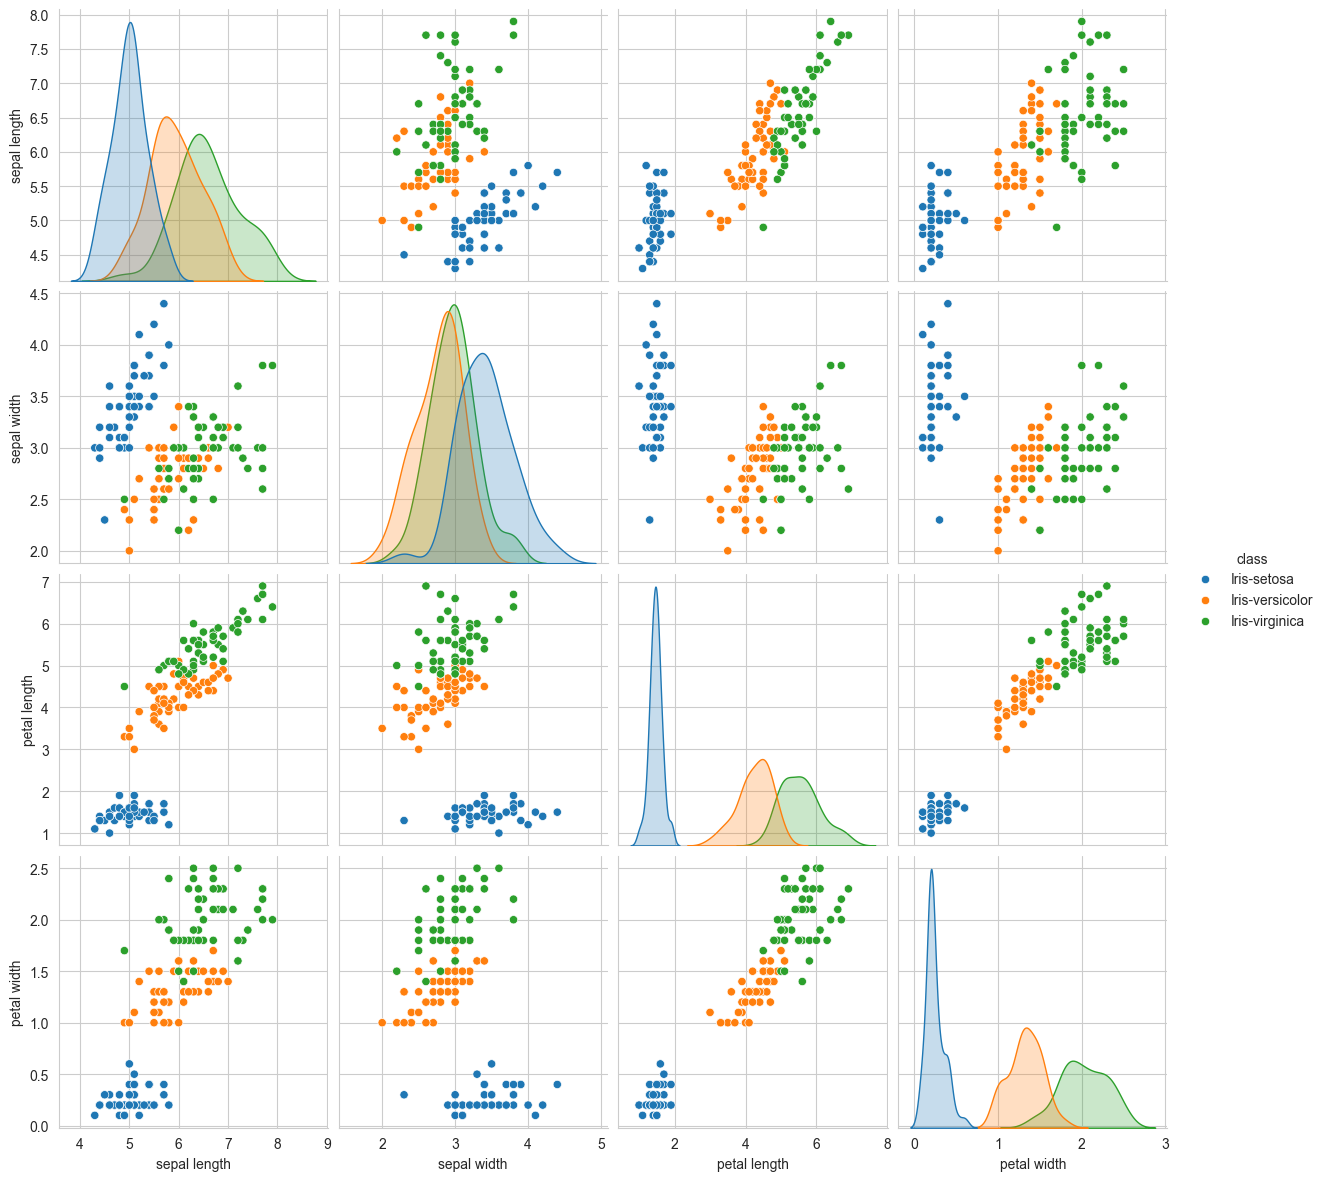

In [7]:
sns.set_style("whitegrid")
sns.pairplot(data=dataframe, hue="class", height=3, diag_kind="kde")

plt.show()

## 2.2 Create BoxSplots for each feature

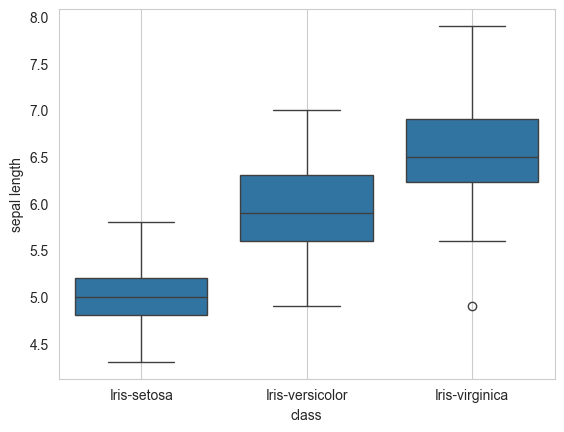

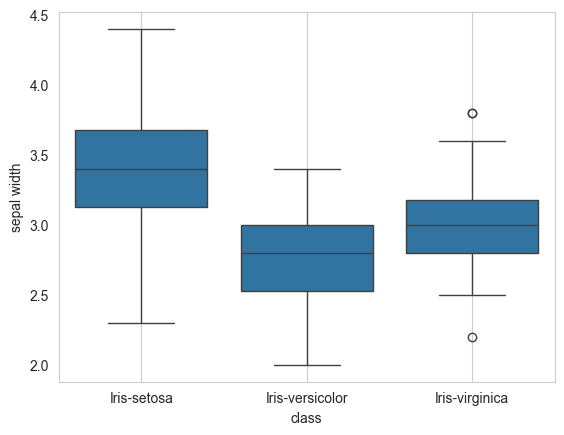

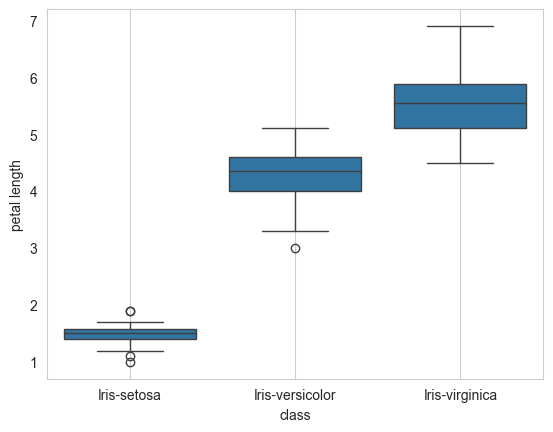

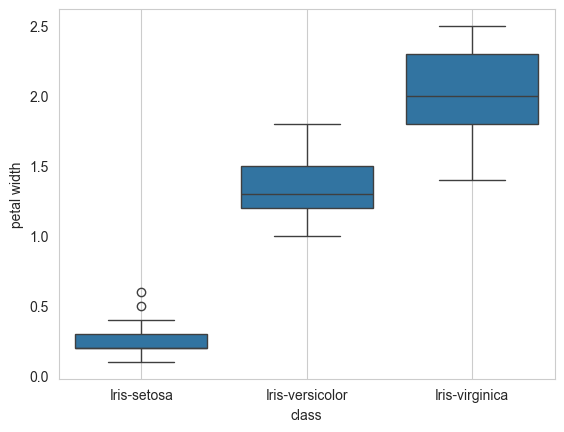

In [8]:
colnames = dataframe.select_dtypes("float64").columns
colnames

for col in dataframe[colnames]:
    plt.figure()
    sns.boxplot(data=dataframe, x="class", y=dataframe[col])
    plt.grid()
    plt.show()

# 3 Test/Train Split - Choose Classifier

## 3.1 Model Performance and Logs

In [9]:
import json
import os
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef

MODEL_FILE_NAME = "model_log.json"
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=1)


def dynamicmodel(model, xtrain, ytrain, xtest, ytest, as_new=False):
    # Generate a unique identifier for the model configuration
    model_config = str(model.get_params())
    print(f"Model: {model.__class__.__name__}")
    model.fit(xtrain, ytrain)
    if not os.path.exists(MODEL_FILE_NAME):
        with open(MODEL_FILE_NAME, "w") as f:
            json.dump({}, f)

    # Load the jason file (if it does not exist it will create it)
    with open(MODEL_FILE_NAME, "r+") as f:
        model_log = json.load(f)

    # Check if the model configuration has been used before
    if (model_config not in model_log) | as_new:
        # Model creation
        ypred = model.predict(xtest)

        # Checking the bias & variance
        train = model.score(xtrain, ytrain)
        test = model.score(xtest, ytest)

        print(f"Training Accuracy: {train}\nTesting Accuracy: {test}\n\n")

        # Model Evaluation
        report = classification_report(ytest, ypred)
        print(report)

        cm = confusion_matrix(ytest, ypred)
        plot_confusion_matrix(cm)

        # MCC
        mcc = matthews_corrcoef(ytest, ypred)
        print("Matthews Correlation Coefficient (MCC):", mcc)

        # Determine the count of the current model configuration
        model_count = sum(1 for key in model_log.keys() if key == model_config)
        model_name = f"{model.__class__.__name__}_{model_count}"

        # Create Directory for the data csv
        create_model_data_dir(model_name, xtrain, ytrain, xtest, ytest)

        # Store results in the log
        model_log[model_config] = {
            "model_name": model_name,
            "data_trained": os.getcwd() + "\\" + model_name,
            "train_accuracy": train,
            "test_accuracy": test,
            "classification_report": report,
            "confusion_matrix": cm.tolist(),
            "mcc": mcc,
        }

        # Write log to a file
        with open(MODEL_FILE_NAME, "w") as f:
            json.dump(model_log, f, indent=4, ensure_ascii=False)
    else:
        print(
            f"Model with hyperparameters has been used before. And the results where:"
        )
        print_model_log(model_config)

    return model


def print_model_log(model_config):
    with open(MODEL_FILE_NAME, "r") as f:
        model_log = json.load(f)

    if model_config in model_log:
        print(f"Model Configuration: {model_config}")
        print(model_log[model_config]["data_trained"])
        print(model_log[model_config]["model_name"])
        print(model_log[model_config]["train_accuracy"])
        print(model_log[model_config]["test_accuracy"])
        print(model_log[model_config]["classification_report"])
        plot_confusion_matrix(model_log[model_config]["confusion_matrix"])
        print(model_log[model_config]["mcc"])
    else:
        print(f"Model with hyperparameters {model_config} not found in the log.")


def create_model_data_dir(model_name, xtrain, ytrain, xtest, ytest):
    if not os.path.exists(model_name):
        os.makedirs(model_name)

        xtrainpath = os.path.join(model_name, "xtrain.csv")
        ytrainpath = os.path.join(model_name, "ytrain.csv")
        xtestpath = os.path.join(model_name, "xtest.csv")
        ytestpath = os.path.join(model_name, "ytest.csv")

        xtrain_df = pd.DataFrame(xtrain)
        ytrain_df = pd.DataFrame(ytrain)
        xtest_df = pd.DataFrame(xtest)
        ytest_df = pd.DataFrame(ytest)

        xtrain_df.to_csv(xtrainpath, index=False)
        ytrain_df.to_csv(ytrainpath, index=False)
        xtest_df.to_csv(xtestpath, index=False)
        ytest_df.to_csv(ytestpath, index=False)


def save_to_unique_csv(df, file_name):
    # Extract the file name and extension
    file_name, file_extension = os.path.splitext(file_name)

    # Initialize the suffix counter
    suffix = 1

    # Generate a unique file name
    while os.path.exists(f"{file_name}_{suffix}{file_extension}"):
        suffix += 1

    # Save the DataFrame to the unique CSV file
    df.to_csv(f"{file_name}_{suffix}{file_extension}", index=False)

    return f"{file_name}_{suffix}{file_extension}"


def create_unique_directory(base_dir):
    # Initialize the suffix counter
    suffix = 1

    # Generate a unique directory name
    while True:
        dir_name = f"{base_dir}_{suffix}"
        if not os.path.exists(dir_name):
            os.makedirs(dir_name)
            return dir_name
        suffix += 1


# Plot confusion matrix
def plot_confusion_matrix(cm):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

    return cm


Model: KNeighborsClassifier
Model with hyperparameters has been used before. And the results where:
Model Configuration: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
C:\Users\Κίμων Χατζόπουλος\Desktop\python\FinartixAssignement\KNeighborsClassifier_0
KNeighborsClassifier_0
0.9523809523809523
0.9777777777777777
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       0.95      1.00      0.97        18
           2       1.00      0.92      0.96        13

    accuracy                           0.98        45
   macro avg       0.98      0.97      0.98        45
weighted avg       0.98      0.98      0.98        45



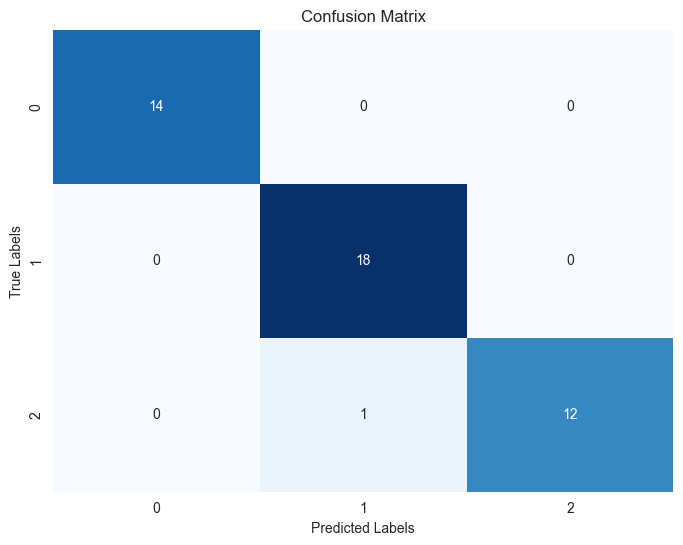

0.9669271325552267
Model: LogisticRegression
Model with hyperparameters has been used before. And the results where:
Model Configuration: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
C:\Users\Κίμων Χατζόπουλος\Desktop\python\FinartixAssignement\LogisticRegression_0
LogisticRegression_0
0.9809523809523809
0.9777777777777777
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      0.94      0.97        18
           2       0.93      1.00      0.96        13

    accuracy                           0.98        45
   macro avg       0.98      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45



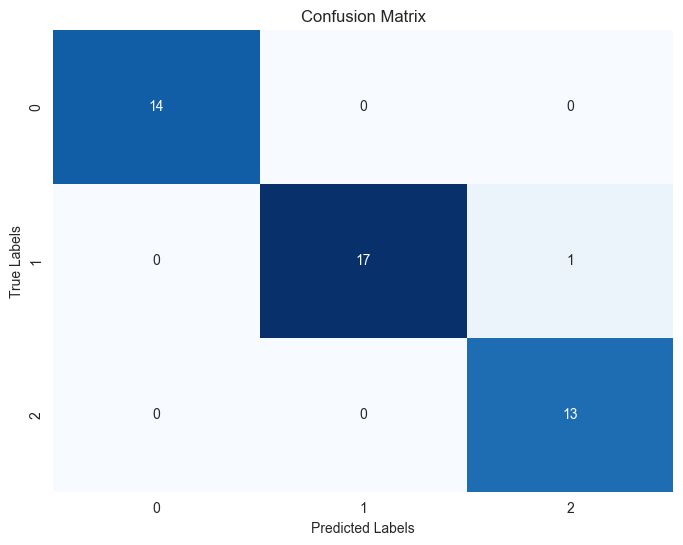

0.9671684881739483
Model: SVC
Model with hyperparameters has been used before. And the results where:
Model Configuration: {'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
C:\Users\Κίμων Χατζόπουλος\Desktop\python\FinartixAssignement\SVC_0
SVC_0
0.9619047619047619
0.9777777777777777
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      0.94      0.97        18
           2       0.93      1.00      0.96        13

    accuracy                           0.98        45
   macro avg       0.98      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45



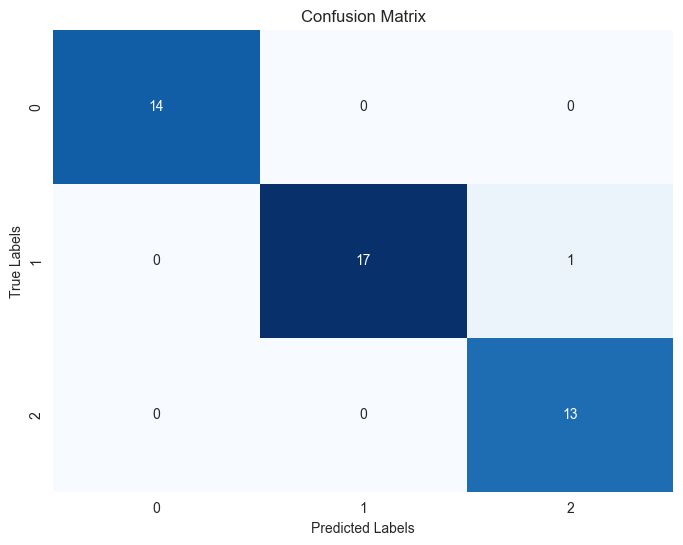

0.9671684881739483
Model: DecisionTreeClassifier
Model with hyperparameters has been used before. And the results where:
Model Configuration: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}
C:\Users\Κίμων Χατζόπουλος\Desktop\python\FinartixAssignement\DecisionTreeClassifier_0
DecisionTreeClassifier_0
1.0
0.9555555555555556
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       0.94      0.94      0.94        18
           2       0.92      0.92      0.92        13

    accuracy                           0.96        45
   macro avg       0.96      0.96      0.96        45
weighted avg       0.96      0.96      0.96        45



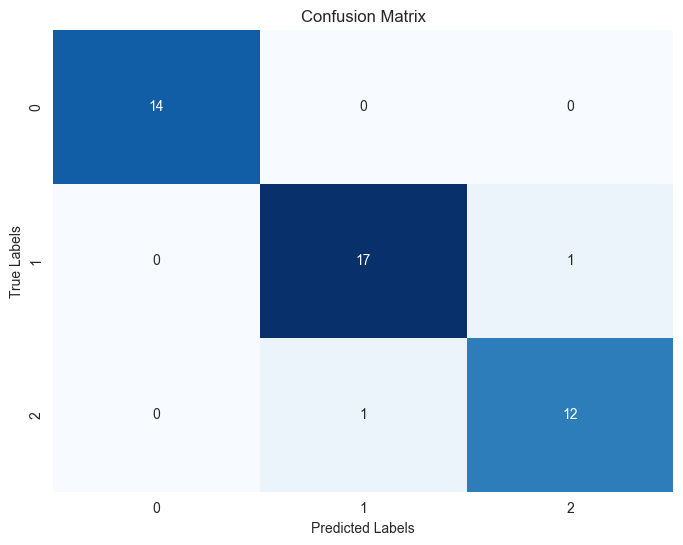

0.9326347305389222
Model: SGDClassifier
Model with hyperparameters has been used before. And the results where:
Model Configuration: {'alpha': 0.0001, 'average': False, 'class_weight': None, 'early_stopping': False, 'epsilon': 0.1, 'eta0': 0.0, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'loss': 'hinge', 'max_iter': 1000, 'n_iter_no_change': 5, 'n_jobs': None, 'penalty': 'l2', 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'tol': 0.001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
C:\Users\Κίμων Χατζόπουλος\Desktop\python\FinartixAssignement\SGDClassifier_0
SGDClassifier_0
0.780952380952381
0.7111111111111111
              precision    recall  f1-score   support

           0       0.54      1.00      0.70        14
           1       1.00      0.28      0.43        18
           2       0.93      1.00      0.96        13

    accuracy                           0.71        45
   macro avg       0.82      0.76      0.70        45
weight

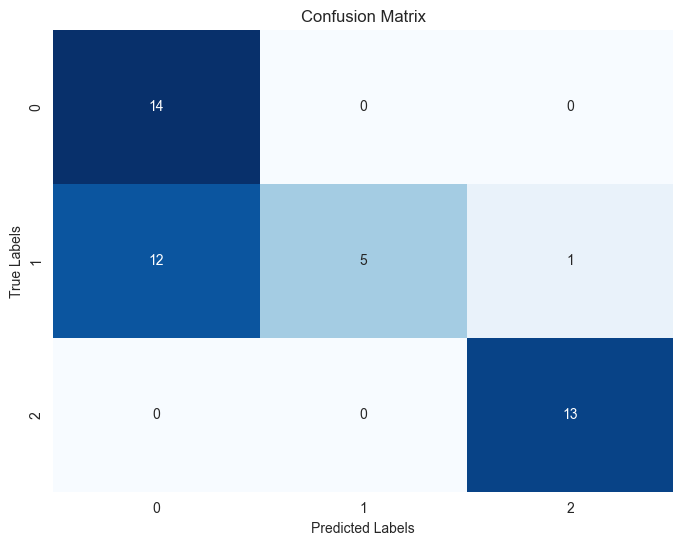

0.6549351054537496


In [10]:
knn = dynamicmodel(KNeighborsClassifier(), xtrain, ytrain, xtest, ytest)
logreg = dynamicmodel(LogisticRegression(), xtrain, ytrain, xtest, ytest)
svm = dynamicmodel(SVC(), xtrain, ytrain, xtest, ytest)
dt = dynamicmodel(DecisionTreeClassifier(), xtrain, ytrain, xtest, ytest)
sgd = dynamicmodel(SGDClassifier(), xtrain, ytrain, xtest, ytest)

Since the magnitudes of the features does not vary there is no need for scaling and as a result no need for a pipeline for now. Most of the models seem to have low bias and high variance.
The most promissing seems to be the Logistic regression one. But following the literature I will go with the Stochastic Gradient Descent (SGD)
and do some hyperparameter tuning to it.

## 3.2 Tuning Parameters

In [11]:
parameters = {
    "loss": [
        "hinge",
        "log_loss",
        "modified_huber",
        "squared_hinge",
        "perceptron",
        "squared_error",
        "huber",
        "epsilon_insensitive",
        "squared_epsilon_insensitive",
    ],
    "penalty": ["l2", "l1", "elasticnet", None],
    "alpha": [i / 10000 for i in range(1, 6)],
    "max_iter": [500, 1000, 2000],
    "learning_rate": ["constant", "optimal", "invscaling", "adaptive"],
}

from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(SGDClassifier(), parameters, verbose=2)
grid.fit(xtrain, ytrain)

Fitting 5 folds for each of 2160 candidates, totalling 10800 fits
[CV] END alpha=0.0001, learning_rate=constant, loss=hinge, max_iter=500, penalty=l2; total time=   0.0s
[CV] END alpha=0.0001, learning_rate=constant, loss=hinge, max_iter=500, penalty=l2; total time=   0.0s
[CV] END alpha=0.0001, learning_rate=constant, loss=hinge, max_iter=500, penalty=l2; total time=   0.0s
[CV] END alpha=0.0001, learning_rate=constant, loss=hinge, max_iter=500, penalty=l2; total time=   0.0s
[CV] END alpha=0.0001, learning_rate=constant, loss=hinge, max_iter=500, penalty=l2; total time=   0.0s
[CV] END alpha=0.0001, learning_rate=constant, loss=hinge, max_iter=500, penalty=l1; total time=   0.0s
[CV] END alpha=0.0001, learning_rate=constant, loss=hinge, max_iter=500, penalty=l1; total time=   0.0s
[CV] END alpha=0.0001, learning_rate=constant, loss=hinge, max_iter=500, penalty=l1; total time=   0.0s
[CV] END alpha=0.0001, learning_rate=constant, loss=hinge, max_iter=500, penalty=l1; total time=   0.0

c:\Users\Κίμων Χατζόπουλος\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
8100 fits failed out of a total of 10800.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8100 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Κίμων Χατζόπουλος\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Κίμων Χατζόπουλος\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^

GridSearchCV(estimator=SGDClassifier(),
             param_grid={'alpha': [0.0001, 0.0002, 0.0003, 0.0004, 0.0005],
                         'learning_rate': ['constant', 'optimal', 'invscaling',
                                           'adaptive'],
                         'loss': ['hinge', 'log_loss', 'modified_huber',
                                  'squared_hinge', 'perceptron',
                                  'squared_error', 'huber',
                                  'epsilon_insensitive',
                                  'squared_epsilon_insensitive'],
                         'max_iter': [500, 1000, 2000],
                         'penalty': ['l2', 'l1', 'elasticnet', None]},
             verbose=2)

## 3.3 Decide best Tuning

In [12]:
grid.best_score_

0.961904761904762

In [13]:
grid.best_estimator_

SGDClassifier(alpha=0.0004, loss='squared_hinge', penalty='l1')

We can notice that even with tuning the SGD Classifier does not perform as well as the Logistic Regression. So we will go on with it.

# 4 Model Evaluation

## Classification report (Accuracy/Precision/Recall/F1 - Confusion Matrix - MCC)

Model: SGDClassifier
Model with hyperparameters has been used before. And the results where:
Model Configuration: {'alpha': 0.0003, 'average': False, 'class_weight': None, 'early_stopping': False, 'epsilon': 0.1, 'eta0': 0.0, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'loss': 'squared_hinge', 'max_iter': 1000, 'n_iter_no_change': 5, 'n_jobs': None, 'penalty': None, 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'tol': 0.001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
C:\Users\Κίμων Χατζόπουλος\Desktop\python\FinartixAssignement\SGDClassifier_0
SGDClassifier_0
0.9047619047619048
0.8222222222222222
              precision    recall  f1-score   support

           0       0.88      1.00      0.93        14
           1       1.00      0.56      0.71        18
           2       0.68      1.00      0.81        13

    accuracy                           0.82        45
   macro avg       0.85      0.85      0.82        45
weighted avg    

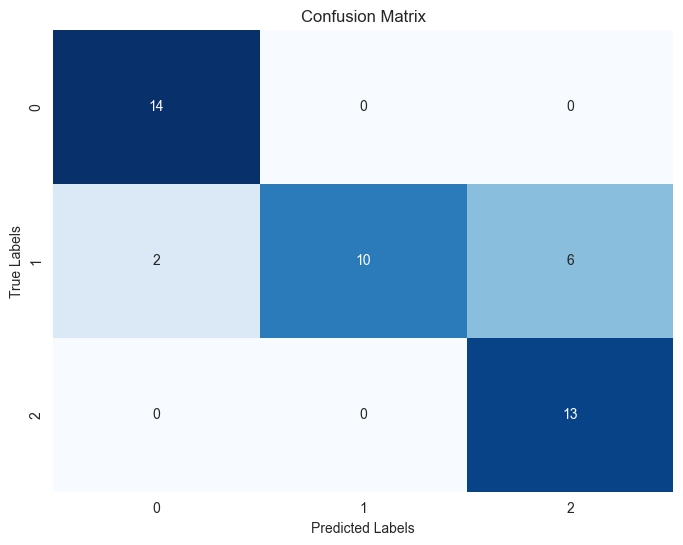

0.7670626808109744


SGDClassifier(alpha=0.0003, loss='squared_hinge', penalty=None)

In [14]:
# Create the best estimator
sgd = SGDClassifier(alpha=0.0003, loss="squared_hinge", penalty=None)
dynamicmodel(sgd, xtrain, ytrain, xtest, ytest)

We have a balanced trade-off between precision and recall. Although a recall of 0.77 is kinda low

MCC of 0.9041146957369786 indicates a relatively good performance of  model

## 4.4 Findings

In [16]:
import inspect


# Extract feature importances
# Note: SGDClassifier doesn't have a built-in attribute to directly retrieve feature importances,
# but we can approximate it by looking at the magnitude of the learned coefficients
def PlotFeatureImportance(model, x_train):
    feature_importances = np.abs(model.coef_)

    plt.figure(figsize=(8, 6))
    plt.barh(range(x_train.shape[1]), feature_importances[0], align="center")
    plt.yticks(range(x_train.shape[1]), x_train.columns)
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature")
    plt.title("Feature Importances in SGD Classifier")
    plt.show()


PlotFeatureImportance(sgd, X)

AttributeError: 'SGDClassifier' object has no attribute 'coef_'

Here we can see how important each feature is. Long story short you can make a preety good estimation just from the petal's length. Let's make a test
by creating a simillar model only using the petal length as a feature.

Model: SGDClassifier
Training Accuracy: 0.8571428571428571
Testing Accuracy: 0.7333333333333333


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      0.33      0.50        18
           2       0.52      1.00      0.68        13

    accuracy                           0.73        45
   macro avg       0.84      0.78      0.73        45
weighted avg       0.86      0.73      0.71        45



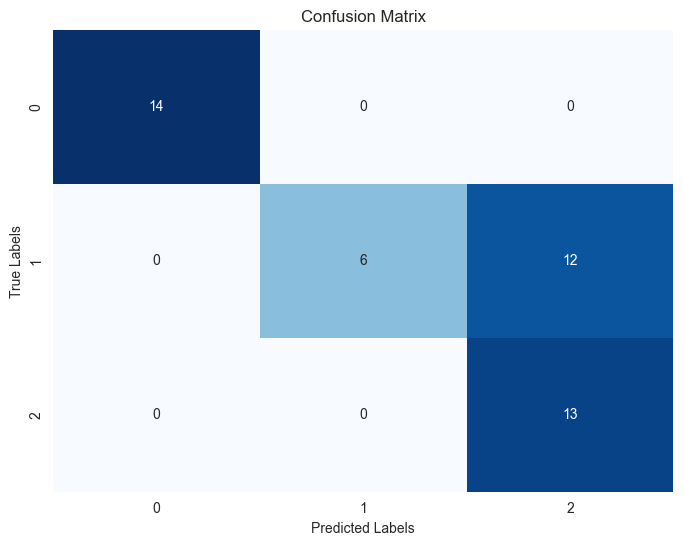

Matthews Correlation Coefficient (MCC): 0.6852501104613512


SGDClassifier(alpha=0.0003, loss='squared_hinge', penalty=None)

In [ ]:
sgd = SGDClassifier(alpha=0.0003, loss="squared_hinge", penalty=None)
dynamicmodel(
    sgd,
    xtrain["petal length"].values.reshape(-1, 1),
    ytrain,
    xtest["petal length"].values.reshape(-1, 1),
    ytest,
    True,
)

So working only with petal length seems even more promissing as working with all 4 features with an sgd model.

# 5 Fask Application

Start the application 

In [ ]:
# Start FlaskApp.py 
%run FlaskApp.py

# Start the Flask application
app.run(debug=False)  # Adjust the parameters as needed

 * Serving Flask app 'FlaskApp'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with stat


SystemExit: 1

 * Serving Flask app 'FlaskApp'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [25/Mar/2024 21:45:00] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [25/Mar/2024 21:45:00] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [25/Mar/2024 21:45:01] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [25/Mar/2024 21:45:03] "GET /reload_model_log HTTP/1.1" 200 -
127.0.0.1 - - [25/Mar/2024 22:16:05] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [25/Mar/2024 22:16:06] "GET /reload_model_log HTTP/1.1" 200 -
127.0.0.1 - - [25/Mar/2024 22:18:48] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [25/Mar/2024 22:18:49] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [25/Mar/2024 22:18:50] "GET /reload_model_log HTTP/1.1" 200 -
127.0.0.1 - - [25/Mar/2024 22:21:56] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [25/Mar/2024 22:21:58] "GET /reload_model_log HTTP/1.1" 200 -
127.0.0.1 - - [25/Mar/2024 22:23:49] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [25/Mar/2024 22:23:51] "GET /reload_model_log HTTP/1.1" 200 -
127.0.0.1 - - [25/Mar/2024 22:25:31] "GET /reload_model_log H